In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
sys.path.insert(0, os.path.join(project_root,"pydplan"))
sys.path.insert(0, os.path.join(project_root,"src"))

from pydplan_profiletools import calculatePlan, DivePlan, TankType
import gf_selection

In [2]:
surface_time = np.linspace(30, 4*60, 30)

combinations = [
    (d, gf_selection.btt[str(d)].max(), s)   # Use the maximum no deco time
    for d in gf_selection.btt.columns[1:-1].astype(int)
    for s in surface_time
]
df = pd.DataFrame(combinations, columns=['d_feet', 'first_dive_time', 'surface_time'])
df['depth'] = df['d_feet']/gf_selection.FEET_IN_METER

# Determine of the maximum no decompression time for a second dive, based on the PADI dive table.
df['no_deco_time'] = df.apply(lambda x: gf_selection.second_dive_no_dec_time(x['first_dive_time'], x['surface_time'], x['d_feet']), axis=1)

# Filter out the cases where first dive is not no deco
df = df[df['no_deco_time'] > 0].copy()

In [3]:
# Find out the high GF which barely allow doing the second dive without decompression stops.
df = gf_selection.parallelize_dataframe(df, gf_selection.get_gf_to_repetative_dives)

For d_feet=130 t1=10, subtract 33 from GF high and add one point every 5 minutes
For d_feet=120 t1=13, subtract 30 from GF high and add one point every 5 minutes
For d_feet=110 t1=16, subtract 36 from GF high and add one point every 4 minutes
For d_feet=100 t1=20, subtract 37 from GF high and add one point every 4 minutes
For d_feet=90 t1=25, subtract 30 from GF high and add one point every 5 minutes
For d_feet=80 t1=30, subtract 34 from GF high and add one point every 5 minutes
For d_feet=70 t1=40, subtract 28 from GF high and add one point every 6 minutes
For d_feet=60 t1=55, subtract 21 from GF high and add one point every 9 minutes
For d_feet=50 t1=80, subtract 14 from GF high and add one point every 15 minutes
For d_feet=40 t1=140, subtract 1 from GF high and add one point every -275 minutes
For d_feet=35 t1=205, subtract -1 from GF high and add one point every -61 minutes


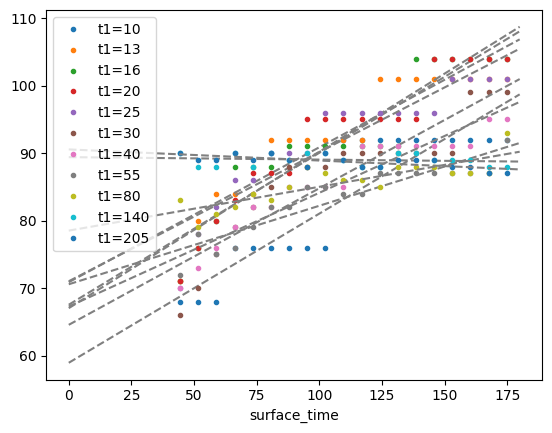

In [4]:
ax = plt.gca()
for first_dive_time, data in df.groupby('first_dive_time'):
    filtered_data = data[
        (data['surface_time'] >= 40)
        & (data['surface_time'] <= 180)
    ]
    filtered_data.plot(x='surface_time', y='gf_high', label=f"t1={first_dive_time:.0f}", marker=".", linewidth=0, ax=ax)
    
    X = filtered_data['surface_time'].values.reshape(-1, 1)
    y = filtered_data['gf_high'].values
    model = LinearRegression().fit(X, y)
    print(f"For d_feet={data['d_feet'].mean():.0f} t1={first_dive_time:.0f}, subtract {y.max() - model.intercept_:.0f} from GF high and add one point every {1/model.coef_[0]:.0f} minutes")
    
    surface_time_range = np.linspace(0, 180, 100).reshape(-1, 1)
    predictions = model.predict(surface_time_range)
    ax.plot(surface_time_range, predictions, linestyle="--", color='gray', label='_nolegend_')

plt.legend()

Conclusion: It doesn't seem that there is a clear trend on how the depth of the dives effects the gradient factor adjustment. For simplicity we can use a single model for values between 70 and 130 feet.

When first dive was to the no deco limit, subtract 37 from GF high and add one point every 5 minutes


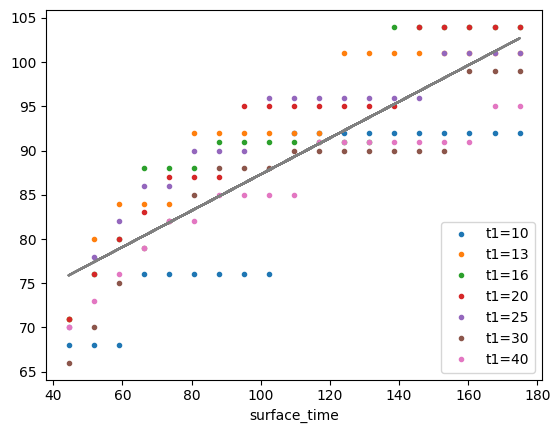

In [5]:
ax = plt.gca()

filtered_data = df[
        (df['surface_time'] >= 40)
        & (df['surface_time'] <= 180)
        & df['d_feet'].between(70, 130)
    ]
X = filtered_data['surface_time'].values.reshape(-1, 1)
y = filtered_data['gf_high']
model = LinearRegression().fit(X, y)
print(f"When first dive was to the no deco limit, subtract {y.max() - model.intercept_:.0f} from GF high and add one point every {1/model.coef_[0]:.0f} minutes")

predictions = model.predict(X)

for first_dive_time, data in filtered_data.groupby('first_dive_time'):
    data.plot(x='surface_time', y='gf_high', label=f"t1={first_dive_time:.0f}", marker=".", linewidth=0, ax=ax)

    filt = filtered_data['depth'] == data['depth'].max()
    ax.plot(filtered_data[filt]['surface_time'], predictions[filt], color='gray', label='_nolegend_')

plt.legend()